In [ ]:
# Required imports
import os.path
from typing import Dict, Tuple
import torch as th
import numpy as np

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

In [ ]:
#main for Equation 2 with MSE loss - density changed around a point.
def main():
    configuration: Configuration = Configuration(
        seed=42,
        features=[64, 32, 16],
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=10_000,
        steps=10_000,
    )

    system_equations = Equation1(
        functions=["x", "y"],
        domain=(0, 9),
        initial_conditions={
            "x": (0, 1),
            "y": (0, 0.5),
        }
    )

    model = Model(
        name="x-x^3",
        configuration=configuration,
        system_equations=system_equations,
    )

    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),  # type: ignore
            os.path.join(load_path, "optimizer.pt"),  # type: ignore
        )
    else:
        model.train_weighted_density(weights=1, 2, 3, 6, 10, 13, 16, 14, 12])
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
# Define custom equations
class Equation2(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        x_trial = real_outputs["x"]
        y_trial = real_outputs["y"]

        lagrangian = 0.5 * y_trial**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        return action

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -x + x ** 3
        return [dxdt, dydt]

In [ ]:
# Main logic
def main():
    configuration: Configuration = Configuration(
        seed=42,
        features=[64, 32, 16],
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=10_000,
        steps=10_000,
    )

    system_equations = Equation2(
        functions=["x", "y"],
        domain=(0, 3),
        initial_conditions={
            "x": (0, 0.5),
            "y": (0, 0.5),
        }
    )

    model = Model(
        name="-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )

    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),  # type: ignore
            os.path.join(load_path, "optimizer.pt"),  # type: ignore
        )
    else:
        model.train()
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
class Equation3(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss using the action integral and a dynamics penalty term.
        """
        # Step 1: Calculate trial solutions
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }

        mse_loss = th.nn.MSELoss(reduction='sum')
        loss1 = mse_loss(
            output_derivatives["x"], real_outputs["y"]
        ) + mse_loss(
            output_derivatives["y"], -real_outputs["x"] + real_outputs["x"] ** 3
        )

        # Step 2: Compute the Lagrangian for the action integral
        lagrangian = 0.5 * real_outputs["y"]**2 - 0.5 * real_outputs["x"]**2 + 0.25 * real_outputs["x"]**4

        # Step 3: Compute the action (integral of the Lagrangian)
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.5  # Weight for the dynamics penalty
        loss = action + lambda_dynamics * loss1

        return loss

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -x + x ** 3
        return [dxdt, dydt]

In [ ]:
# Main logic
def main():
    configuration: Configuration = Configuration(
        seed=4235,
        features=[64, 32, 16],
        activation_function=th.nn.Tanh(),
        learning_rate=0.002,
        epochs=10_000,
        steps=10_000,
    )

    system_equations = Equation3(
        functions=["x", "y"],
        domain=(0, 8 ),
        initial_conditions={
            "x": (0, 0.5),
            "y": (0, 0.53),
        }
    )

    model = Model(
        name="-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )

    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),  # type: ignore
            os.path.join(load_path, "optimizer.pt"),  # type: ignore
        )
    else:
        model.train()
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
class Equation4(SystemEquations):
    def calculate_trial_solution(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> Dict[str, th.Tensor]:
        # Only compute x_trial using the x output of the model
        x_trial = self.initial_conditions["x"][1] + (inputs / self.domain[1] - self.initial_conditions["x"][0]) * outputs["x"]

        # Compute y_trial as the derivative of x_trial
        y_trial = compute_derivative(inputs, x_trial)

        return {"x": x_trial, "y": y_trial}  # Dynamically generate y_trial

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        # Extract trial solutions
        x_trial = real_outputs["x"]
        y_trial = real_outputs["y"]  # Derived as the derivative of x_trial

        # Compute derivatives of trial solutions
        x_dot = compute_derivative(inputs, x_trial)
        y_dot = compute_derivative(inputs, y_trial)

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        loss = mse_loss(
            x_dot, y_trial  # Enforces y = \dot{x}
        ) + mse_loss(
            y_dot, -x_trial + x_trial**3  # Enforces \dot{y} = -x + x^3
        )

        return loss

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -x + x**3
        return [dxdt, dydt]

In [ ]:
# Main logic
def main():
    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=42,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=5_000,
        steps=10_000,
    )

    # Define the system equations for x'' = -x + x^3
    system_equations = Equation4(
        functions=["x", "y"],  # x and y = dx/dt
        domain=(0, 4),  # Time domain
        initial_conditions={
            "x": (0, 1),  # Initial condition x(0) = 1
            "y": (0, 0.2),  # Initial condition y(0) = 0.2
        }
    )

    # Create the model
    model = Model(
        name="-x+x^3",  # Model name for saving results
        configuration=configuration,
        system_equations=system_equations,
    )

    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
    else:
        model.train()
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
# Try to calculate with x''
class Equation2(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }

        mse_loss = th.nn.MSELoss()

        loss = mse_loss(
            output_derivatives["x"], real_outputs["y"]
        ) + mse_loss(
            output_derivatives["y"], real_outputs["x"] - real_outputs["x"] ** 3
        )

        return loss

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = x - x ** 3
        return [dxdt, dydt]


class Equation3(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }

        mse_loss = th.nn.MSELoss()

        loss = mse_loss(
            output_derivatives["x"], real_outputs["y"]
        ) + mse_loss(
            output_derivatives["y"], real_outputs["x"] - real_outputs["x"] ** 3
        )

        return loss

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = x - x ** 3
        return [dxdt, dydt]


class Equation3(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Compute the action integral for this specific system.
        """
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        # Extract position (x) and velocity (y)
        x = real_outputs["x"]
        #y = real_outputs["y"]
        y = compute_derivative(inputs, x)  # Compute y(t) = dx/dt

        
        # Define the Lagrangian: L = y^2 / 2 + (x^2 / 3 - x^4 / 3)
        lagrangian = 0.5 * y**2 + (x**2 / 2) - (x**4 /4)

        # Compute the action (integral of the Lagrangian over the domain)
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))
        return action

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = x - x ** 3
        return [dxdt, dydt]


class Equation4(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }

        x = real_outputs["x"]
        y = real_outputs["y"]
        z = real_outputs["z"]
        w = real_outputs["w"]

        mse_loss = th.nn.MSELoss()

        loss = mse_loss(
            output_derivatives["x"], y + z - w
        ) + mse_loss(
            output_derivatives["y"], x - z
        ) + mse_loss(
            output_derivatives["z"], x + y - 2 * z
        ) + mse_loss(
            output_derivatives["w"], -x + w
        )

        return loss

    def system(self, t, u):
        x, y, z, w = u
        dxdt = y + z - w
        dydt = x - z
        dzdt = x + y - 2 * z
        dwdt = -x + w
        return [dxdt, dydt, dzdt, dwdt]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system
def system(t, z):
    x, y = z
    dxdt = y
    dydt = -x + x**3
    return [dxdt, dydt]

# Generate trajectories in phase space
x_values = np.linspace(-1,1, 10)  # Initial x positions
y_values = np.linspace(-1, 1, 10)  # Initial y velocities
t_span = (0, 1)  # Time range for simulation
t_eval = np.linspace(*t_span, 1000)  # Time points for evaluation

plt.figure(figsize=(8, 8))
for x0 in x_values:
    for y0 in y_values:
        sol = solve_ivp(system, t_span, [x0, y0], t_eval=t_eval)
        plt.plot(sol.y[0], sol.y[1], lw=0.7)  # Plot x vs y in phase space

# Add energy contours (optional)
x = np.linspace(-2.5, 2.5, 500)
y = np.linspace(-2.5, 2.5, 500)
X, Y = np.meshgrid(x, y)
H = 0.5 * Y**2 + 0.5 * X**2 - 0.25 * X**4
plt.contour(X, Y, H, levels=20, linewidths=0.5, colors="gray", linestyles="dotted")

# Customize plot
plt.title("Phase Space of $x'' = -x + x^3$")
plt.xlabel("$x$")
plt.ylabel("$y = \dot{x}$")
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]
        y_trial = trial_solutions["y"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        y_dot = compute_derivative(inputs, y_trial)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        # Loss enforces both x' = y and y' = -x + x^3
        loss = mse_loss(x_dot, y_trial) + mse_loss(y_dot, self.equation(x_trial, y_trial, inputs))
        return loss


# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=500,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.1),  # x(t_0) = x_0
            "y": (0, 0.386)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )

    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
# Required imports
import os.path
from typing import Dict, Tuple
import torch as th
import numpy as np

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary


# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        # Loss enforces both x' = y and y' = -x + x^3
        loss = mse_loss(x_double_dot, -x_trial + x_trial ** 3)
        return loss


# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=500,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.5),  # x(t_0) = x_0
            "y": (3, -0.5)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder(SecondOrderEquations):
    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]
        y_trial = trial_solutions["y"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        y_dot = compute_derivative(inputs, y_trial)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        # Loss enforces both x' = y and y' = -x + x^3
        loss = mse_loss(x_dot, y_trial) + mse_loss(y_dot, self.equation(x_trial, y_trial, inputs))
        return loss


# Main logic
def main():
    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=2_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.5),  # x(t_0) = x_0
            "y": (3, 0.3),  # x'(t_0) = y_0
        }
    )

    # Create the model
    model = Model(
        name="second_order_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )

    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == 


#Dirichlet; erros; colocar extra Hamilton; gráfico (x,x')


In [ ]:
''' Dirichlet with MSE error '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        # Loss enforces both x' = y and y' = -x + x^3
        loss = mse_loss(x_double_dot, -x_trial + x_trial ** 3)
        return loss


# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=500,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.5),  # x(t_0) = x_0
            "y": (3, -0.5)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action integral'''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder2(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        x_trial = real_outputs["x"]
        x_dot = real_outputs["y"]

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        return action

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=2_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder2(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.5),  # x(t_0) = x_0
            "y": (3, -0.5)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action + lambda*MSE (enforcing dynamics) '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder3(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss1 = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.5  # Weight for the dynamics penalty
        loss = action + lambda_dynamics * loss1

        return action

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=4332865,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=2_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder3(
        function="x",  # Only one function for second-order problems
        domain=(0, 3),  # Time domain
        initial_conditions={
            "x": (0, 0.5),  # x(t_0) = x_0
            "y": (3, -0.5)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action + lambda*MSE +alfa*MSE(H) '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder4(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()
        mse_loss2 = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss1 = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        loss2 = mse_loss(th.tensor(0.25, dtype=x_trial.dtype, device=x_trial.device), 
                 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.0  # Weight for the dynamics penalty
        alpha_dynamics = 0.0
        loss = action + lambda_dynamics * loss1 + alpha_dynamics * loss2
        #print(f"Action: {action.item()}, MSE Eq: {loss1.item()}, MSE H: {loss2.item()}, Total Loss: {loss.item()}")

        return loss

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=43365,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=2_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder4(
        function="x",  # Only one function for second-order problems
        domain=(-5, 5),  # Time domain
        initial_conditions={
            "x": (-5, -1),  # x(t_0) = x_0
            "y": (5, 1)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action + lambda*MSE +alfa*MSE(H) '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder4(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()
        mse_loss2 = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss1 = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        loss2 = mse_loss2(th.tensor(0.25, dtype=x_trial.dtype, device=x_trial.device), 
                 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.0  # Weight for the dynamics penalty
        alpha_dynamics = 1.0
        loss = action + lambda_dynamics * loss1 + alpha_dynamics * loss2
        #print(f"Action: {action.item()}, MSE Eq: {loss1.item()}, MSE H: {loss2.item()}, Total Loss: {loss.item()}")

        return loss

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=43365,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=5_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder4(
        function="x",  # Only one function for second-order problems
        domain=(-5, 5),  # Time domain
        initial_conditions={
            "x": (-5, -1),  # x(t_0) = x_0
            "y": (5, 1)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action + lambda*MSE +alfa*MSE(H) '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder4(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()
        mse_loss2 = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss1 = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        loss2 = mse_loss2(th.tensor(0.25, dtype=x_trial.dtype, device=x_trial.device), 
                 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.0  # Weight for the dynamics penalty
        alpha_dynamics = 0.0
        loss = action + lambda_dynamics * loss1 + alpha_dynamics * loss2
        #print(f"Action: {action.item()}, MSE Eq: {loss1.item()}, MSE H: {loss2.item()}, Total Loss: {loss.item()}")

        return loss

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=43365,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=200_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder4(
        function="x",  # Only one function for second-order problems
        domain=(-6, 6),  # Time domain
        initial_conditions={
            "x": (-6, -1),  # x(t_0) = x_0
            "y": (6, 1)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' Dirichlet with action + lambda*MSE(dynamics) +alfa*MSE(Hamiltonean) '''

# Define the second-order differential equation: x'' = -x + x^3
class EquationSecondOrder4(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -x + x^3.
        """
        return -x + x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Define and calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()
        mse_loss2 = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss_dynamics = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)

        # Compute Lagrangian gradient (numerical differentiation)
        L_gradients = compute_derivative(inputs, lagrangian)  # dL/dt

        # Define threshold for truncation based on Lagrangian gradient
        epsilon_L = 0.01
        N = 20  # Number of consecutive points that must satisfy |L'| < epsilon_L

        # Find where |L'| is small
        valid_indices = th.where(th.abs(L_gradients) < epsilon_L)[0]

        # Ensure there are enough points to consider truncation
        if len(valid_indices) >= N:
            # Split into negative and positive time indices
            neg_indices = valid_indices[inputs[valid_indices] < 0]  # Indices where t < 0
            pos_indices = valid_indices[inputs[valid_indices] > 0]  # Indices where t > 0
        
            # Select truncation points separately for each side
            A_neg = inputs[neg_indices[-N]].item() if len(neg_indices) >= N else inputs[0].item()
            A_pos = inputs[pos_indices[-N]].item() if len(pos_indices) >= N else inputs[-1].item()
        
            # A should be the maximum positive value
            A_value = max(abs(A_neg), abs(A_pos))
        else:
            A_value = inputs[-1].item()  # Default to max t if condition is never met
        
        print(A_value)  # Check if A is properly set
        
        # Find indices at the extremes
        left_idx = (inputs < -A_value).nonzero(as_tuple=True)[0]  # Indices where t < -A
        right_idx = (inputs > A_value).nonzero(as_tuple=True)[0]   # Indices where t > A
        
        # Create a new mask that removes only extreme values
        mask = th.ones_like(inputs, dtype=th.bool)  # Start with all True
        if len(left_idx) > 0:
            mask[left_idx] = False  # Remove left extreme values
        if len(right_idx) > 0:
            mask[right_idx] = False  # Remove right extreme values
        
        # Apply the new mask
        truncated_inputs = inputs[mask]
        truncated_lagrangian = lagrangian[mask]
        
        # Compute the truncated action integral
        action = th.trapz(truncated_lagrangian.view(-1), truncated_inputs.view(-1))

        loss_hamiltonean = mse_loss2(th.tensor(0.25, dtype=x_trial.dtype, device=x_trial.device), 
                 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)
        
        lambda_dynamics = 0.0
        alpha_dynamics = 0.0
        loss = action + lambda_dynamics * loss_dynamics + alpha_dynamics * loss_hamiltonean
        #print(f"Action: {action.item()}, MSE Eq: {loss1.item()}, MSE H: {loss2.item()}, Total Loss: {loss.item()}")

        return loss

# Main logic
def main():
    
    boundary_type = "dirichlet"  # "pvi" or "dirichlet"

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=43365,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=4_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder4(
        function="x",  # Only one function for second-order problems
        domain=(-10, 10),  # Time domain
        initial_conditions={
            "x": (-10, -1),  # x(t_0) = x_0
            "y": (10, 1)   # x(t_1) = x_1: since it is dirichlet expect values of the boundaries.
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=-x+x^3",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
''' DELETE FOR PROF VERSION'''

import numpy as np
import scipy.integrate

# Define the hyperbolic tangent heteroclinic solution
def x_heteroclinic(t):
    return np.tanh(t / np.sqrt(2))

# Compute the derivative x' = dx/dt
def x_prime_heteroclinic(t):
    return (1 / np.sqrt(2)) * (1 - np.tanh(t / np.sqrt(2))**2)

# Define the Lagrangian function
def lagrangian_heteroclinic(t):
    x = x_heteroclinic(t)
    x_prime = x_prime_heteroclinic(t)
    return 0.5 * x_prime**2 - 0.5 * x**2 + 0.25 * x**4

# Compute the action integral using adaptive quadrature
action_value_small, error = scipy.integrate.quad(lagrangian_heteroclinic, -1000000000, 1000000000)

# Print the result
print(f"Approximated Action Value from t=-1 to t=1: {action_value_small:.6f}")


In [ ]:
''' DELETE FOR PROF VERSION'''

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Define the hyperbolic tangent heteroclinic solution
def x_heteroclinic(t):
    return np.tanh(t / np.sqrt(2))

# Compute the derivative x' = dx/dt
def x_prime_heteroclinic(t):
    return (1 / np.sqrt(2)) * (1 - np.tanh(t / np.sqrt(2))**2)

# Define the Lagrangian function
def lagrangian_heteroclinic(t):
    x = x_heteroclinic(t)
    x_prime = x_prime_heteroclinic(t)
    return 0.5 * x_prime**2 - 0.5 * x**2 + 0.25 * x**4

# Compute the action integral using adaptive quadrature
action_value_small, error = scipy.integrate.quad(lagrangian_heteroclinic, -1000, 1000)

# Generate values for plotting
t_vals = np.linspace(-1000, 1000, 500)  # High-resolution time range
lagrangian_vals = lagrangian_heteroclinic(t_vals)

# Plot the Lagrangian function
plt.figure(figsize=(8, 5))
plt.plot(t_vals, lagrangian_vals, label=r"L(x, x')", color='b')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Lagrangian L(x, y)')
plt.title(r'Lagrangian L(x, y) for the Heteroclinic Orbit')
plt.legend()
plt.grid()
plt.show()

# Print the computed action integral
print(f"Approximated Action Value from t=-1 to t=1: {action_value_small:.6f}")


In [ ]:
''' Dirichlet with action + lambda*MSE +alfa*MSE(H) '''

# Define the second-order differential equation: x'' = sin(x)
class EquationSecondOrder5(SecondOrderEquations):
    def __init__(self, function: str, domain: Tuple[float, float], initial_conditions: Dict[str, Tuple[float, float]], boundary_type: str = "pvi"):
        """
        Initializes the specific second-order differential equation.

        Args:
            function (str): Name of the dependent variable.
            domain (Tuple[float, float]): Time domain.
            initial_conditions (Dict[str, Tuple[float, float]]): Initial conditions for the function and its derivative.
            boundary_type (str, optional): Type of boundary conditions ("pvi" or "dirichlet"). Default is "pvi".
        """
        super().__init__(function, domain, initial_conditions, boundary_type)  # Pass boundary type

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = - sin(x)
        """
        return -np.sin(x)

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss function to enforce the dynamics of the equation.
        """
        # Get trial solutions
        
        trial_solutions = self.calculate_trial_solution(inputs, outputs)
        x_trial = trial_solutions["x"]

        # Compute derivatives
        x_dot = compute_derivative(inputs, x_trial)  # First derivative
        x_double_dot = compute_derivative(inputs, x_dot)  # Second derivative

        # Use MSE to enforce the dynamics
        mse_loss = th.nn.MSELoss()
        mse_loss2 = th.nn.MSELoss()

        # Loss enforcing dynamics
        loss1 = mse_loss(x_double_dot, -x_trial + x_trial ** 3)

        lagrangian = (0.5 * x_dot**2 + th.cos(x_trial))
        
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        loss2 = mse_loss2(th.tensor(0.25, dtype=x_trial.dtype, device=x_trial.device), 
                 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)

        # Step 5: Combine action and penalty terms
        lambda_dynamics = 0.0  # Weight for the dynamics penalty
        alpha_dynamics = 0.0
        loss = action + lambda_dynamics * loss1 + alpha_dynamics * loss2
        #print(f"Action: {action.item()}, MSE Eq: {loss1.item()}, MSE H: {loss2.item()}, Total Loss: {loss.item()}")

        return loss

# Main logic
def main():
    
    boundary_type = "dirichlet"  # Change to "pvi" for initial value problems

    # Configuration for the neural network and training
    configuration: Configuration = Configuration(
        seed=43365,
        features=[64, 32, 16],  # Neural network architecture
        activation_function=th.nn.Tanh(),
        learning_rate=0.001,
        epochs=10_000,
        steps=10_000,
    )

    # Define the second-order system equations
    system_equations = EquationSecondOrder5(
        function="x",  # Only one function for second-order problems
        domain=(-9, 9),  # Time domain
        initial_conditions={
            "x": (-9, -th.pi),  # x(t_0) = x_0
            "y": (9, 3*th.pi)   # x'(t_0) = y_0
        },
        boundary_type=boundary_type  # Single change here
    )

    # Create the model
    model = Model(
        name=f"second_order_{boundary_type}_x''=sin(x)",
        configuration=configuration,
        system_equations=system_equations,
    )
    
    # Training and testing
    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
        
    else:
        model.train()
    model.test()


# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
class Equation4(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss using the action.
        """
        # Step 1: Calculate trial solutions
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        # Extract trial solutions for x and y
        x_trial = real_outputs["x"]
        y_trial = real_outputs["y"]

        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }
        
        x_dot = output_derivatives["x"]
        y_dot = output_derivatives["y"]

        # Step 2: Compute the Lagrangian for the action integral
        g = 9.81  # Gravity constant
        lagrangian = 0.5 * (x_dot**2 + y_dot**2 + 2 * x_dot * y_dot * th.cos(x_trial - y_trial)) + g * (2 * th.cos(x_trial) + th.cos(y_trial))

        action = th.trapz(lagrangian.view(-1), inputs.view(-1))
        
        loss = action

        return loss

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -x + x ** 3
        return [dxdt, dydt]


# Main logic
def main():
    configuration: Configuration = Configuration(
        seed=4235,
        features=[64, 32, 16],
        activation_function=th.nn.Tanh(),
        learning_rate=0.002,
        epochs=1_000,
        steps=10_000,
    )

    system_equations = Equation4(
        functions=["x", "y"],
        domain=(0, 1),
        initial_conditions={
            "x": (0, 0.5),
            "y": (0, 0.53),
        }
    )

    model = Model(
        name="double-pendulum",
        configuration=configuration,
        system_equations=system_equations,
    )

    load_path = None  # Update this if you have a pre-trained model path
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),  # type: ignore
            os.path.join(load_path, "optimizer.pt"),  # type: ignore
        )
    else:
        model.train()
    model.test()

# Execute the main function
if __name__ == "__main__":
    main()

Summary completed.


  3%|█                                      | 56/2000 [00:01<00:49, 39.27it/s]

Epoch 50/2000, Loss: 1.674947


  5%|██                                    | 106/2000 [00:02<00:47, 39.67it/s]

Epoch 100/2000, Loss: 1.063647


  8%|██▉                                   | 154/2000 [00:03<00:47, 39.24it/s]

Epoch 150/2000, Loss: -0.311944


 10%|███▉                                  | 205/2000 [00:05<00:45, 39.22it/s]

Epoch 200/2000, Loss: -8.878869


 13%|████▊                                 | 254/2000 [00:06<00:44, 39.62it/s]

Epoch 250/2000, Loss: -14.358065


 15%|█████▊                                | 307/2000 [00:07<00:42, 39.49it/s]

Epoch 300/2000, Loss: -17.399739


 18%|██████▊                               | 357/2000 [00:09<00:41, 39.87it/s]

Epoch 350/2000, Loss: -18.789614


 20%|███████▋                              | 406/2000 [00:10<00:41, 38.67it/s]

Epoch 400/2000, Loss: -19.721178


 23%|████████▋                             | 457/2000 [00:11<00:38, 39.87it/s]

Epoch 450/2000, Loss: -20.392732


 25%|█████████▋                            | 507/2000 [00:12<00:38, 39.14it/s]

Epoch 500/2000, Loss: -20.902838


 28%|██████████▌                           | 554/2000 [00:14<00:36, 39.77it/s]

Epoch 550/2000, Loss: -21.303764


 30%|███████████▍                          | 605/2000 [00:15<00:35, 39.57it/s]

Epoch 600/2000, Loss: -21.640057


 33%|████████████▍                         | 657/2000 [00:16<00:33, 39.70it/s]

Epoch 650/2000, Loss: -25.495033


 35%|█████████████▍                        | 708/2000 [00:18<00:33, 38.27it/s]

Epoch 700/2000, Loss: -26.789526


 38%|██████████████▎                       | 755/2000 [00:19<00:31, 39.80it/s]

Epoch 750/2000, Loss: -27.438285


 40%|███████████████▎                      | 806/2000 [00:20<00:29, 40.27it/s]

Epoch 800/2000, Loss: -27.910292


 43%|████████████████▏                     | 854/2000 [00:21<00:28, 39.56it/s]

Epoch 850/2000, Loss: -28.296385


 45%|█████████████████▏                    | 904/2000 [00:23<00:28, 39.14it/s]

Epoch 900/2000, Loss: -28.615176


 48%|██████████████████▏                   | 957/2000 [00:24<00:26, 39.55it/s]

Epoch 950/2000, Loss: -28.882289


 50%|██████████████████▋                  | 1007/2000 [00:25<00:24, 39.74it/s]

Epoch 1000/2000, Loss: -29.115318


 53%|███████████████████▍                 | 1054/2000 [00:26<00:23, 39.96it/s]

Epoch 1050/2000, Loss: -29.314957


 55%|████████████████████▍                | 1104/2000 [00:28<00:23, 38.82it/s]

Epoch 1100/2000, Loss: -29.494856


 58%|█████████████████████▎               | 1155/2000 [00:29<00:21, 39.85it/s]

Epoch 1150/2000, Loss: -29.651525


 60%|██████████████████████▎              | 1203/2000 [00:30<00:19, 40.06it/s]

Epoch 1200/2000, Loss: -29.790338


 63%|███████████████████████▎             | 1257/2000 [00:32<00:19, 39.02it/s]

Epoch 1250/2000, Loss: -29.914244


 65%|████████████████████████▏            | 1305/2000 [00:33<00:17, 38.64it/s]

Epoch 1300/2000, Loss: -30.025169


 68%|█████████████████████████            | 1357/2000 [00:34<00:16, 38.71it/s]

Epoch 1350/2000, Loss: -30.124693


 70%|██████████████████████████           | 1406/2000 [00:35<00:15, 39.37it/s]

Epoch 1400/2000, Loss: -30.214701


 73%|██████████████████████████▉          | 1456/2000 [00:37<00:13, 39.50it/s]

Epoch 1450/2000, Loss: -30.295194


 75%|███████████████████████████▊         | 1504/2000 [00:38<00:12, 39.42it/s]

Epoch 1500/2000, Loss: -30.358859


 78%|████████████████████████████▊        | 1556/2000 [00:39<00:11, 38.84it/s]

Epoch 1550/2000, Loss: -30.435159


 80%|█████████████████████████████▋       | 1604/2000 [00:41<00:10, 39.07it/s]

Epoch 1600/2000, Loss: -30.495355


 83%|██████████████████████████████▋      | 1656/2000 [00:42<00:08, 39.39it/s]

Epoch 1650/2000, Loss: -30.548039


 85%|███████████████████████████████▌     | 1704/2000 [00:43<00:07, 39.08it/s]

Epoch 1700/2000, Loss: -30.599523


 88%|████████████████████████████████▍    | 1753/2000 [00:44<00:06, 36.37it/s]

Epoch 1750/2000, Loss: -30.634260


 90%|█████████████████████████████████▍   | 1805/2000 [00:46<00:04, 39.19it/s]

Epoch 1800/2000, Loss: -30.685719


 93%|██████████████████████████████████▎  | 1857/2000 [00:47<00:03, 39.43it/s]

Epoch 1850/2000, Loss: -30.714474


 95%|███████████████████████████████████▏ | 1905/2000 [00:48<00:02, 37.66it/s]

Epoch 1900/2000, Loss: -30.757308


 98%|████████████████████████████████████▏| 1957/2000 [00:50<00:01, 39.19it/s]

Epoch 1950/2000, Loss: -30.788193


100%|█████████████████████████████████████| 2000/2000 [00:51<00:00, 39.02it/s]


Epoch 2000/2000, Loss: -30.816907


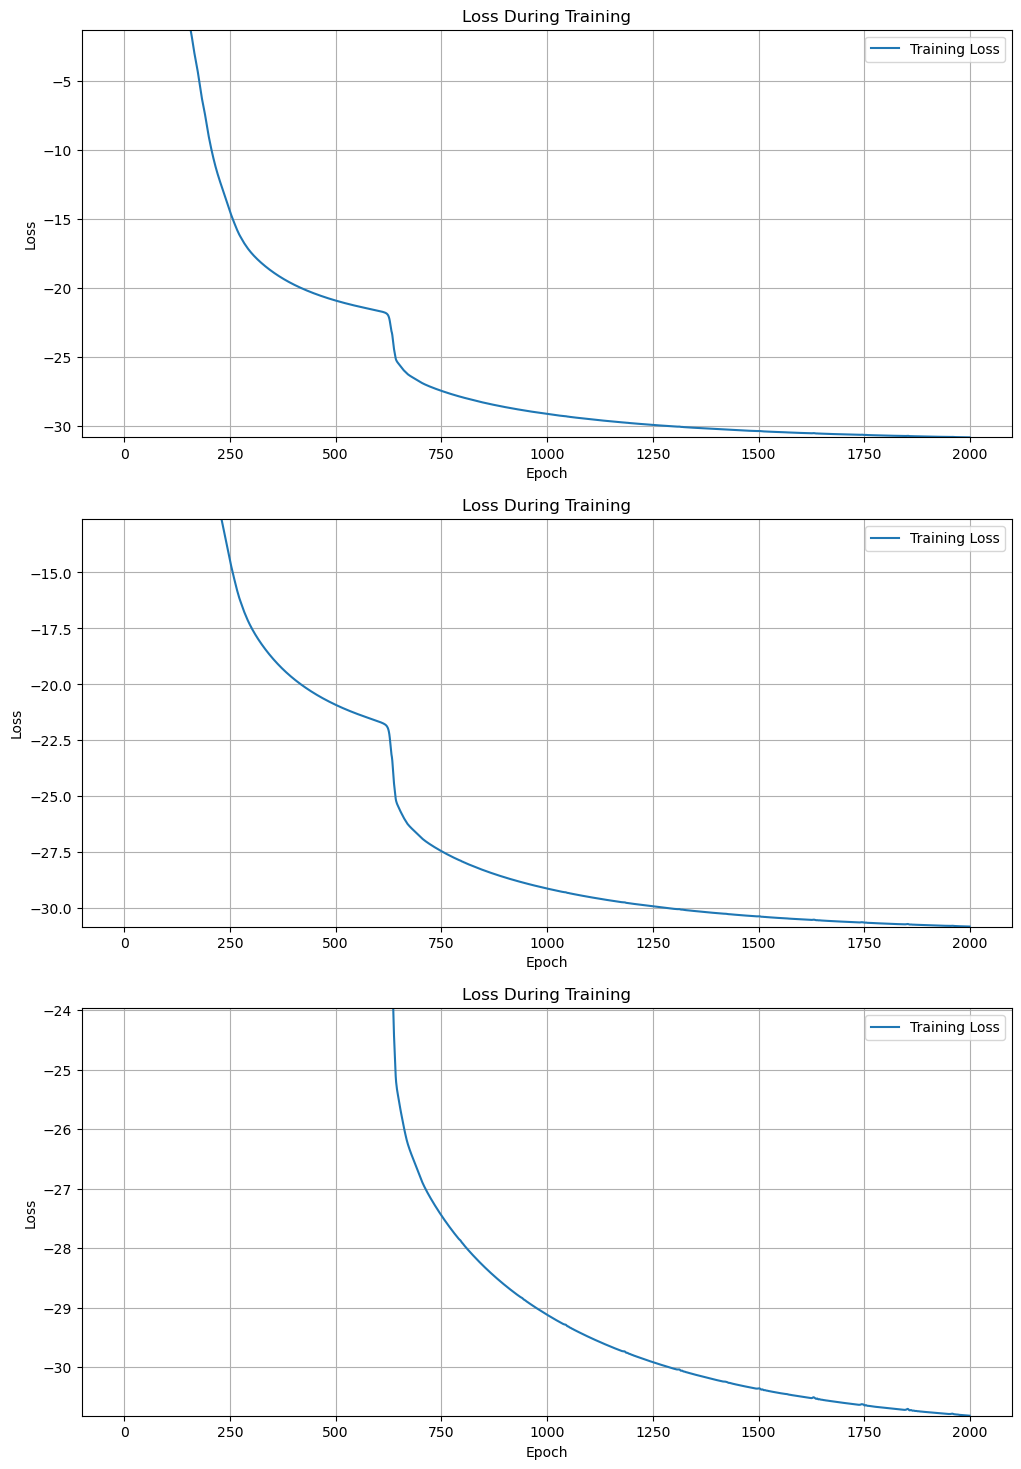

[[0.1       ]
 [0.1020336 ]
 [0.10406719]
 ...
 [3.12310143]
 [3.12309172]
 [3.12308199]]
[[0.15      ]
 [0.14859974]
 [0.14719948]
 ...
 [3.12417237]
 [3.12419535]
 [3.12421839]]


ValueError: not enough values to unpack (expected 4, got 2)

In [1]:
# Required imports
import os.path
from typing import Dict, Tuple
import torch as th
import numpy as np

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

class DoublePendulum(SystemEquations):
    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:
        """
        Calculate the loss using the action integral for the double pendulum.
        """
        # Step 1: Calculate trial solutions
        real_outputs = self.calculate_trial_solution(inputs, outputs)

        # Compute derivatives
        output_derivatives = {
            function: compute_derivative(inputs, real_output)
            for function, real_output in real_outputs.items()
        }

        x1_trial = real_outputs["x"]
        x2_trial = real_outputs["y"]

        x1_dot = output_derivatives["x"]
        x2_dot = output_derivatives["y"]

        g = 9.81  # Gravity

        # Step 2: Compute the equations of motion
        #denominator = 2 - th.cos(x1_trial - x2_trial)**2

       # f1 = (-g * (2 * th.sin(x1_trial) + th.sin(x2_trial) * th.cos(x1_trial - x2_trial)) - x2_dot**2 * th.sin(x1_trial - x2_trial)) / denominator

       # f2 = ((2 * th.sin(x1_trial) + th.sin(x2_trial) * th.cos(x1_trial - x2_trial)) * th.cos(x1_trial - x2_trial) + 2 * x1_dot**2 * th.sin(x1_trial - x2_trial)) / denominator

        # Step 3: Compute loss based on the difference between NN derivatives and physical derivatives
        # mse_loss = th.nn.MSELoss(reduction='sum')
       # loss1 = mse_loss(y1_dot, f1) + mse_loss(y2_dot, f2)

        # Step 4: Compute the Lagrangian
        lagrangian = 0.5 * (x1_dot**2 + x2_dot**2 + 2 * x1_dot * x2_dot * th.cos(x1_trial - x2_trial)) + g * (2 * th.cos(x1_trial) + th.cos(x2_trial))

        # Step 5: Compute the action integral
        action = th.trapz(lagrangian.view(-1), inputs.view(-1))

        # Step 6: Combine action and penalty terms
        lambda_dynamics = 0.0
        loss = action

        return loss

    def system(self, t, z):
        x1, x2, y1, y2 = z
        g = 9.81
        denominator = 2 - np.cos(x1 - x2)**2

        dx1dt = y1
        dx2dt = y2

        dy1dt = (-g * (2 * np.sin(x1) + np.sin(x2) * np.cos(x1 - x2)) - y2**2 * np.sin(x1 - x2)) / denominator
        dy2dt = ((2 * np.sin(x1) + np.sin(x2) * np.cos(x1 - x2)) * np.cos(x1 - x2) + 2 * y1**2 * np.sin(x1 - x2)) / denominator

        return [dx1dt, dx2dt, dy1dt, dy2dt]

def main():
    configuration: Configuration = Configuration(
        seed=4235,
        features=[64, 32, 16],
        activation_function=th.nn.Tanh(),
        learning_rate=0.002,
        epochs=2_000,
        steps=10_000,
    )

    system_equations = DoublePendulum(
        functions=["x", "y"],
        domain=(0, 2),
        initial_conditions = {
            "x1": (0, th.tensor(0.1)),
            "x2": (0, th.tensor(0.15)),
            "y1": (0, th.tensor(0.0)), 
            "y2": (0, th.tensor(0.0)),
        }

    )

    model = Model(
        name="double-pendulum",
        configuration=configuration,
        system_equations=system_equations,
    )

    load_path = None  # Update if you have a pre-trained model
    if load_path is not None:
        model.load(
            os.path.join(load_path, "model.pt"),
            os.path.join(load_path, "optimizer.pt"),
        )
    else:
        model.train()
    model.test()

if __name__ == "__main__":
    main()